# Project Discrete Optimization and Decision Making

## First point

This project involves designing an efficient last-mile delivery system for a city. A company has a set of customers $C = \{1, \ldots, \overline{c}\}$, each requiring the delivery of a package. The weight of each package $w_c, c \in C$ is known. The delivery time for each customer is equal to $s_c, c \in C$. The company has a set $K = \{1, \ldots, \overline{k}\}$ of delivery vans available that all start from the same depot $0$ at time $0$, have the same capacity $W$, and must return to the depot withing $t_{max}$. Each vehicle can exit the depot at most once. The problem can be formulated on a complete directed graph $G = (V, A)$ where $V = C \cup \{0\}$ is the set of nodes and $A = \{(i,j) | i, j \in V, i \neq j\}$ is the set of arcs. Each arc can be traveled at most once by any of the vehicles. For each arc $(i, j) \in A$, let us define the time $t_{ij}$ required to travel over the arc. Travel times satisfy the triangle inequality. The goal of the company is to minimize the total time required to complete the service for all customers. Provide a mathematical formulation of the problem and its optimal solution. 

### Mathematical Model

## New

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import gurobipy as gp
from gurobipy import GRB

In [198]:
numberOfCustomers = 5
vehicleCapacity = 10
numberOfVehicles = 3
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}
xCoordinates = [30, 20, 10, 10, 40, 50, 30]
yCoordinates = [30, 40, 45, 30, 10, 30, 30]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
print(costMatrix)
print(demandOfCustomers)

[[ 0. 14. 25. 20. 22. 20.  0.]
 [14.  0. 11. 14. 36. 31. 14.]
 [25. 11.  0. 15. 46. 42. 25.]
 [20. 14. 15.  0. 36. 40. 20.]
 [22. 36. 46. 36.  0. 22. 22.]
 [20. 31. 42. 40. 22.  0. 20.]
 [ 0. 14. 25. 20. 22. 20.  0.]]
{1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}


In [176]:
class FirstPointGurobi:
    def __init__(self, numberOfCustomers, customersDemand, numberOfVehicles, VehicleCapacity, costMatrix):
        self.numberOfCustomers = numberOfCustomers
        self.customersDemand = customersDemand
        self.numberOfVehicles = numberOfVehicles
        self.VehicleCapacity = VehicleCapacity
        self.costMatrix = costMatrix
        self.initializeLP()

    def initializeLP(self):
        self.model = gp.Model('Capacitated Vehicle Routing Problem')
        # Variables
        x = self.model.addVars(len(self.costMatrix), len(self.costMatrix), vtype=GRB.BINARY, name="x")
        # Cumulated demand on the route that visits node j up to this visit
        y = self.model.addVars(len(self.costMatrix), vtype=GRB.CONTINUOUS, name="y")
        self.model.setObjective(gp.quicksum(self.costMatrix[i, j] * x[i, j] for i in range(len(self.costMatrix)) for j in range(len(self.costMatrix)) if i!=j), GRB.MINIMIZE)

        # Each customer must be visited exactly once
        for i in range(1, len(self.costMatrix)-1):
            constraint1 = None
            for j in range(1, len(self.costMatrix)):
                if i != j:
                    if constraint1 == None:
                        constraint1 = x[i,j]
                    else:
                        constraint1 += x[i,j]
            self.model.addConstr(constraint1 == 1)
        # self.model.addConstrs(gp.quicksum(x[i, j] for j in range(1,self.numberOfCustomers+1) if j != i) == 1 for i in range(1, self.numberOfCustomers))

        # Correct flow of vehicles through the arcs

        # Maximum number of routes to K, number of vehicles
        # self.model.addConstr(gp.quicksum(x[0, j] for j in range(1,self.numberOfCustomers)) <= self.numberOfVehicles)
        constraint2 = None
        # Do not include the depot
        for j in range(1, len(self.costMatrix)-1):
            if constraint2 == None:
                constraint2 = x[0,j]
            else:
                constraint2 = constraint2 + x[0,j]
        self.model.addConstr(constraint2 <= self.numberOfVehicles)
        ########### CAPACITY ################
        # Ensure that the capacity is not exceeded
        for i in range(len(self.costMatrix)-1):
            constraint3a, contraint3b = None, None
            constraint3a = self.customersDemand[i] <= y[i]
            constraint3b = y[i] <= self.VehicleCapacity
            self.model.addConstr(constraint3a)
            self.model.addConstr(constraint3b)
        #####################################
        for i in range(len(self.costMatrix)):
            for j in range(len(self.costMatrix)):
                constraint4 = None
                if i != j:
                    constraint4 = y[j] >= y[i] + self.customersDemand[j] * x[i,j] - self.VehicleCapacity*(1-x[i,j])
                    self.model.addConstr(constraint4)
        for h in range(1, len(self.costMatrix)-1):
            constraint5a, constraint5b = None, None
            for i in range(len(self.costMatrix)-1):
                if i != h:
                    if constraint5a == None:
                        constraint5a = x[i,h]
                    else:
                        constraint5a += x[i,h]
            for j in range(1, len(self.costMatrix)):
                if j != h:
                    if constraint5b == None:
                        constraint5b = x[h,j]
                    else:
                        constraint5b += x[h,j]
            self.model.addConstr(constraint5a - constraint5b == 0)


    def solve(self):
        status = self.model.optimize()
        print(status)
	
    def getResult(self):
        print("Objective value: ", self.model.ObjVal)
        for v in self.model.getVars():
            print(v.varName, " = ", v.x)   
        return self.model

In [177]:
lp = FirstPointGurobi(numberOfCustomers, demandOfCustomers, numberOfVehicles, vehicleCapacity, costMatrix)
lp.solve()
result = lp.getResult()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 65 rows, 56 columns and 218 nonzeros
Model fingerprint: 0x201d13c0
Variable types: 7 continuous, 49 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 154.0000000
Presolve removed 46 rows and 37 columns
Presolve time: 0.00s
Presolved: 19 rows, 19 columns, 80 nonzeros
Variable types: 5 continuous, 14 integer (14 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       154.00000  154.00000  0.00%     -    0s

Explored 1 

In [199]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.getVars():
    if('x' in v.varName and v.x == 1):
        #print(v.name, " = ", v.varValue)
        temp = (v.varName.split('[')[1].split(']')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        setList.append(list(set(set1)))

[(0, 1), (1, 2), (2, 6)]
[(0, 3), (3, 6)]
[(0, 5), (5, 4), (4, 6)]


[[[30.0, 30.0], [20.0, 40.0], [10.0, 45.0], [30.0, 30.0]], [[30.0, 30.0], [10.0, 30.0], [30.0, 30.0]], [[30.0, 30.0], [40.0, 10.0], [50.0, 30.0], [30.0, 30.0]]]


/var/folders/w9/9ttssfw10dz5_5y9qbn2j2xw0000gn/T/ipykernel_1590/2239118552.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')


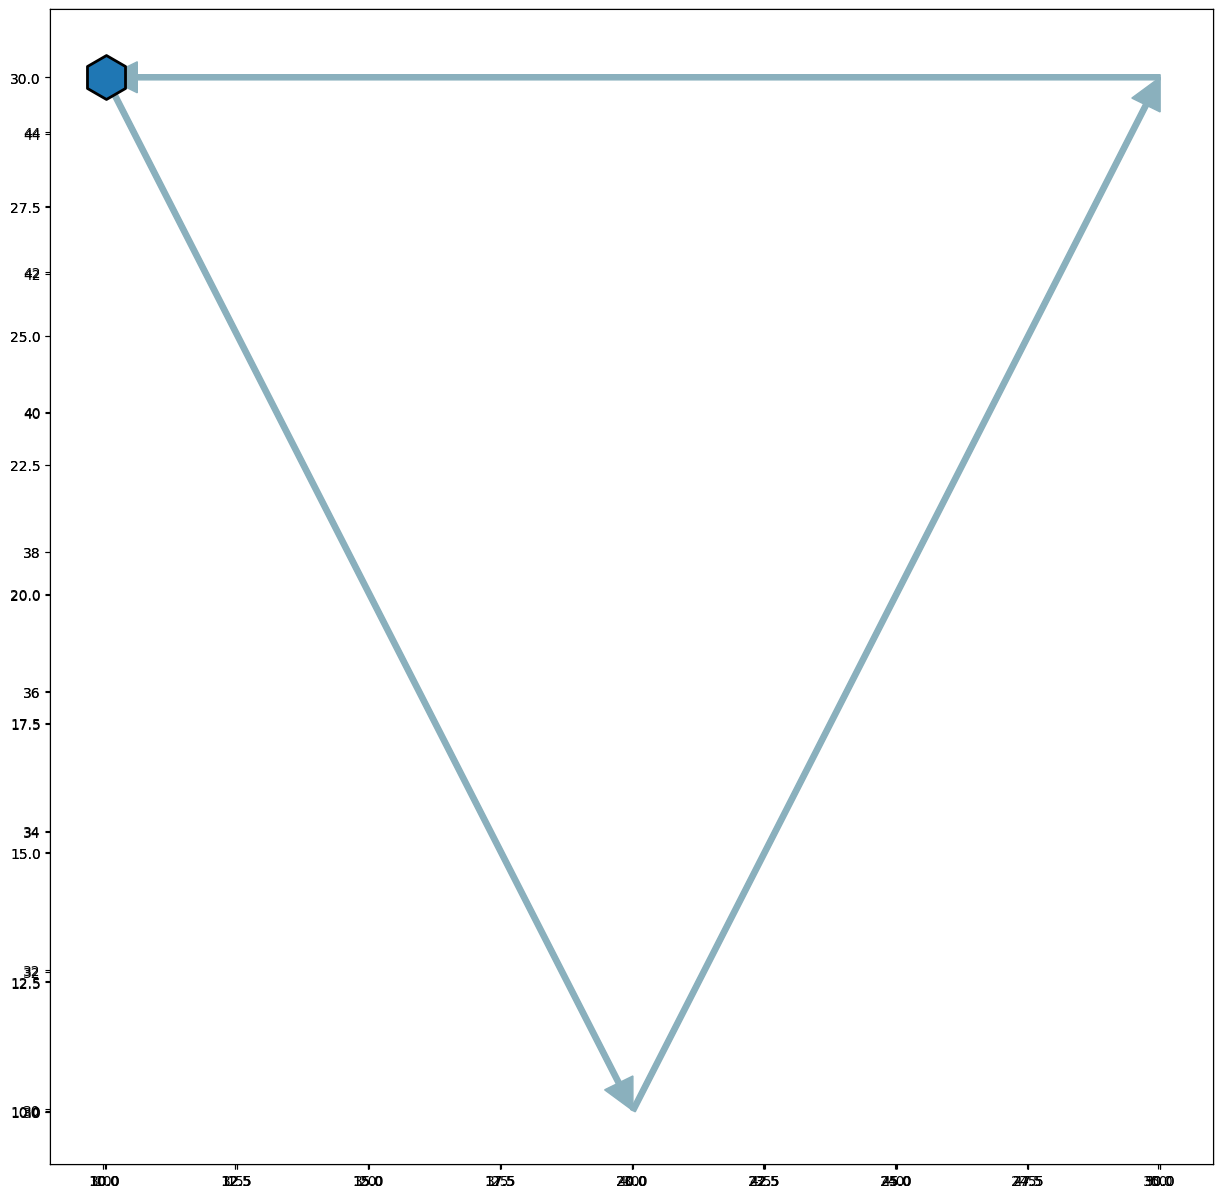

In [204]:
# Visualization
plt.figure(figsize=(15,15))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
for i in range(len(coordinateList)):
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], edgecolor='black', linewidth=2, s=1000, marker='h')
plt.show()